In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm.notebook import tqdm

from resnet import ResNet
from mahalanobis import compute_centers_cov, mahalanobis_score, metrics_eval

mean_std = {
    'svhn':((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    'cifar10':((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    'cifar100':((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
}

ID_dataset = 'cifar10'
OOD_dataset = 'svhn'
train_dataset = 'cifar10_train'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*mean_std[ID_dataset]),
])

dataset_classes = {
    'svhn':torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform),
    'svhn_train':torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform),
    'cifar10':torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform),
    'cifar10_train':torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    #'cifar100':torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform),
    #'cifar100_train':torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
}

trainset = dataset_classes[train_dataset]
ID = dataset_classes[ID_dataset]
OOD = dataset_classes[OOD_dataset]
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=False, num_workers=2)
ID_loader = torch.utils.data.DataLoader(ID, batch_size=500,shuffle=False,  num_workers=2)
OOD_loader = torch.utils.data.DataLoader(OOD, batch_size=500,shuffle=True,  num_workers=2)

In [ ]:
models = {
    'svhn':'./models/resnet34/svhn_9626_final',
    'cifar10':'./models/resnet34/cifar10_9184',
    'cifar100':'./models/resnet34/cifar100_6722'
}
num_classes = {
    'svhn':10,
    'cifar10':10,
    'cifar100':100
}
num_per_class = {
    'svhn':None,
    'cifar10':5000,
    'cifar100':500
}
model = torch.load(models[ID_dataset]).cuda()
model.eval()

layers = 17 #last feature layer


centers_cov_matrices = [compute_centers_cov(trainloader, model, layer, num_classes[ID_dataset],
                                            num_per_class[ID_dataset]) for layer in range(layers)]

Below we compute the evaluation metrics for different magnitudes when we consider CIFAR-10 as IN-Distribution (positive) and SVNH as OOD (negative). We are using test samples from these datasets.

In [8]:
eps = 0.00000015 # This tiny quantity added to all covariance matrices is here to prevent divisions by zero
                 # from happening
centers=[centers_cov_matrices[layer][0] for layer in range(layers)]
inv_cov_matrix = [torch.inverse(centers_cov_matrices[layer][1] +eps*torch.ones(centers_cov_matrices[layer][1].size()).cuda()) for layer in range(layers)]


score_mag={}
metrics={}
    

In [ ]:
from sklearn.metrics import roc_auc_score
from odin import get_posterior
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

#Changing magnitudes
magnitudes=[0.005]

for layer in range(1,17):
    print("Layer:", layer)
    
    k=0
    centres=centers[layer]
    inv_cov=inv_cov_matrix[layer]
    for magnitude in magnitudes:
        print('magnitude', magnitude)
        scores_ID=[]
        scores_OOD=[]
  
        for data_in, data_out in tqdm(zip(ID_loader,OOD_loader)):

            batch_ID= data_in[0].cuda()
            scores_ID1 = mahalanobis_score(batch_ID, model, centres, inv_cov , magnitude=magnitude, layer=layer)

            #To test ODIN's results
            #scores_ID1 = get_posterior(batch_ID, model, magnitude=magnitude, temperature=t)


            lis_scores=list(scores_ID1.cpu().numpy())
            scores_ID=scores_ID+ lis_scores

            batch_OOD= data_out[0].cuda()
            scores_OOD1 = mahalanobis_score(batch_OOD, model, centres, inv_cov, magnitude=magnitude, layer=layer)

            #To test ODIN's results
            #scores_OOD1=get_posterior(batch_OOD, model, magnitude=magnitude, temperature=t)

            lis_scores= list(scores_OOD1.cpu().numpy())
            scores_OOD= scores_OOD + lis_scores

            k+=500
            if k>=10000: break


        eval_metrics= metrics_eval(scores_ID,scores_OOD)
        metrics[magnitude]={}
        metrics[magnitude][layer]=eval_metrics
        print(eval_metrics)

        

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=120)
sns.set_style('dark')
sns.distplot(scores_ID.cpu(), hist = True, kde = True, kde_kws = {'linewidth': 2}, label='ID')
sns.distplot(scores_OOD.cpu(), hist = True, kde = True, kde_kws = {'linewidth': 2}, label='OOD')
plt.legend(loc='upper right')
plt.show()

# Evolution of Mahalnobis performance with layers (ends of blocks):

In [ ]:
import numpy as np
scores_layers=np.load('data/scoresCIFAR10_SVHN_10000_withoutDA.npy')
labels_layers=np.load('data/labelsCIFAR10_SVHN_10000_withoutDA.npy')

<Figure size 720x480 with 0 Axes>

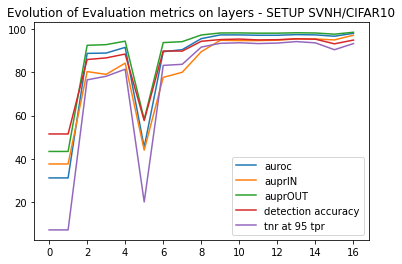

In [5]:
from mahalanobis import metrics_eval
import pandas as pd
import matplotlib.pyplot as plt
resultats={}

criteria= ['auroc', 'auprIN', 'auprOUT', 'detection accuracy', 'tnr at 95 tpr']

for criterion in criteria:
    resultats[criterion]=np.zeros(np.shape(scores_layers)[1])
    scores_ID= scores_layers[labels_layers==0]
    scores_OOD= scores_layers[labels_layers==1]
    
    for layer in range(np.shape(scores_layers)[1]):
        resultats[criterion][layer]=metrics_eval(scores_ID[:,layer], scores_OOD[:,layer])[criterion]

results_layers= pd.DataFrame.from_dict(resultats)

plt.figure(dpi=120)
#ax= results_layers.plot.bar(y='auroc',title="Evolution of Evaluation metrics on layers - SETUP SVNH/CIFAR10")

ax= results_layers.plot(title="Evolution of Evaluation metrics on layers - SETUP SVNH/CIFAR10")


plt.show() 

fig = ax.get_figure()
#fig.savefig('results/auroc_evol_layers_svnh_cifar10.png')
fig.savefig('results/evol_layers_svnh_cifar10.png')




In [6]:
results_layers

,auroc,auprIN,auprOUT,detection accuracy,tnr at 95 tpr
0,31.105036,37.567340,43.359680,51.46,7.02
1,31.105036,37.567340,43.359680,51.46,7.02
2,88.774096,80.347921,92.511526,85.94,76.52
3,88.928460,79.069678,92.835667,86.69,78.18
4,91.556592,84.261762,94.437730,88.47,81.44
5,45.311472,43.969613,58.140117,57.69,19.98
6,89.543380,77.654519,93.779587,89.90,83.22
7,90.517292,80.037628,94.213948,89.83,83.72
8,95.611880,89.572109,97.309092,94.38,91.70
9,97.328940,94.853583,98.227158,95.18,93.44


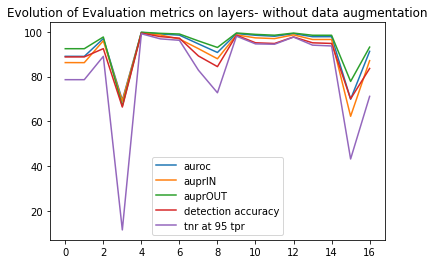

In [20]:
#Results without data augmentation
import numpy as np
scores_layers=np.load('data/scoresCIFAR10_SVHN_5000_withoutDA.npy')
labels_layers=np.load('data/labelsCIFAR10_SVHN_5000_withoutDA.npy')
from mahalanobis import metrics_eval
import pandas as pd
resultats={}

criteria= ['auroc', 'auprIN', 'auprOUT', 'detection accuracy', 'tnr at 95 tpr']

for criterion in criteria:
    resultats[criterion]=np.zeros(np.shape(scores_layers)[1])
    scores_ID= scores_layers[labels_layers==0]
    scores_OOD= scores_layers[labels_layers==1]
    
    for layer in range(np.shape(scores_layers)[1]):
        resultats[criterion][layer]=metrics_eval(scores_ID[:,layer], scores_OOD[:,layer])[criterion]

results_layers= pd.DataFrame.from_dict(resultats)

results_layers.plot(title="Evolution of Evaluation metrics on layers- without data augmentation")
